In [4]:
from __future__ import print_function
import sys
import os
import time
import csv
import math
import random
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import tensorflow as tf
from tensorflow.contrib.layers.python import layers as tf_layers
from FunGenerator import FunGenerator
from sklearn.neighbors import DistanceMetric
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
path = '/mnt/WanChai/Dropbox/Tensorflow-Mostly/MetaLearning/maml_ht/FitFunShapes/'
home = '/mnt/WanChai/Dropbox/Tensorflow-Mostly/MetaLearning/maml_ht'
os.chdir(home)

fnm1 = 'MLPparam_Dist_Loss_TrainData-iter5k-start-from-lastParamMean.pkl'
fnm2 = 'MLPparam_Dist_Loss_TrainData-iter200k-randomStart.pkl'
fnm3 = 'InitW_and_initBias.pkl'

In [3]:
f = open(path+fnm2, 'rb')
xx = pickle.load(f)
param = xx['param']
xx = pickle.load(f)
dist = xx['dist_from_start']
xx = pickle.load(f)
loss_train = xx['loss_train']
xx = pickle.load(f)
loss_val = xx['loss_val']
xx = pickle.load(f)
yrange_train = xx['yrange_train']
xx = pickle.load(f)
Hn = xx['Hn']
xx = pickle.load(f)
Grid = xx['Grid']
xx = pickle.load(f)
funX = xx['funX']
xx = pickle.load(f)
funY = xx['funY']
xx = pickle.load(f)
Lambda = xx['Lambda']
xx = pickle.load(f)
loss_threshold = xx['loss_threshold']
xx = pickle.load(f)
Ntrain = xx['Ntrain']
xx = pickle.load(f)
Nval = xx['Nval']
xx = pickle.load(f)
Ntest = xx['Ntest']
xx = pickle.load(f)
max_iter = xx['max_iter']
xx = pickle.load(f)
min_iter = xx['min_iter']
xx = pickle.load(f)
xrng = xx['xrng']
xx = pickle.load(f)
use_init_file = xx['use_init_file']
f.close()

print('param len:', len(param))
print('param[0] len:', len(param[1]))
print('dist len:', len(dist))
print('loss_train len:', len(loss_train))
print('loss_val len:', len(loss_val))
print('yrange_train len:', len(yrange_train))
print('Hn:', Hn)
print('Grid shape:', Grid.shape)
print('funX shape:', funX.shape)
print('funY shape:', funY.shape)
print('Lambda:', Lambda)
print('loss_threshold:', loss_threshold)
print('Ntrain:', Ntrain)
print('Nval:', Nval)
print('Ntest:', Ntest)
print('max_iter:', max_iter)
print('min_iter:', min_iter)
print('xrng:', xrng)
print('use_init_file:', use_init_file)

param len: 193
param[0] len: 481
dist len: 192
loss_train len: 192
loss_val len: 192
yrange_train len: 192
Hn: [20, 20]
Grid shape: (192, 4)
funX shape: (192, 400, 1)
funY shape: (192, 400, 1)
Lambda: 0.02
loss_threshold: 1.0
Ntrain: 200
Nval: 100
Ntest: 100
max_iter: 100000
min_iter: 10000
xrng: [-15.707963267948966, 15.707963267948966]
use_init_file: False


In [4]:
loss_last = [ll[-1] for ll in loss_train]
loss_val_last = [ll[-1] for ll in loss_val]
print('loss_last len', len(loss_last))
print(loss_last[:10])

loss_last len 192
[0.8690561, 0.7282736, 0.6247058, 0.97422034, 0.9418678, 0.95583975, 0.7491814, 0.8344044, 0.8492783, 1.0041835]


In [10]:
param_mat = np.array(param)
print('param shape:', param_mat.shape)
param_mat1 = param_mat[1:,:]
print('param1 shape:', param_mat1.shape)

param shape: (193, 481)
param1 shape: (192, 481)


In [70]:
# location indices on the flat param vector 'colmean'
h0 = Hn[0]
h1 = Hn[0]*Hn[1] + h0
h2 = h1 + Hn[1]
h3 = h2 + Hn[0]
h4 = h3 + Hn[1]
h5 = h4 + 1

In [72]:
W1 = param_mat1[:,:h0]
W2 = param_mat1[:,h0:h1]
W3 = param_mat1[:,h1:h2]
b1 = param_mat1[:,h2:h3]
b2 = param_mat1[:,h3:h4]
b3 = param_mat1[:,h4:h5]
print(W1.shape)
print(W2.shape)
print(W3.shape)
print(b1.shape)
print(b2.shape)
print(b3.shape)

(192, 20)
(192, 400)
(192, 20)
(192, 20)
(192, 20)
(192, 1)


In [80]:
allW = param_mat1[:,:h2]
print(allW.shape)
print(allW)

(192, 440)
[[-5.33176422e-01 -3.36659133e-01 -4.64153647e-01 ... -1.36854302e-04
   7.26568323e-05  3.23750952e-04]
 [-7.36414804e-05 -4.39772248e-01 -2.83498734e-01 ...  5.52247453e-04
  -3.33342105e-01 -2.57826061e-04]
 [-3.72407705e-01 -7.89227247e-01 -4.32065129e-01 ...  9.96292710e-01
   2.27909040e-05 -2.93495541e-05]
 ...
 [-1.46650243e+00 -1.71367252e+00 -2.61017354e-04 ...  4.25358489e-03
   1.25235915e-02 -8.02076280e-01]
 [ 3.08348890e-03 -1.23335016e+00  7.65537739e-01 ... -1.11688930e-03
  -8.77220416e-04 -6.04929752e-04]
 [-4.78964150e-01 -1.24974644e+00 -1.39697862e-03 ...  7.82158866e-04
  -3.33241478e-04  4.20913013e-04]]


In [74]:
Dist = DistanceMetric.get_metric('euclidean')
Dmat = Dist.pairwise(allW)
print('Dmat :', Dmat.shape)

Dmat : (192, 192)


In [79]:
Z = linkage(allW, 'ward')
fig = plt.figure(figsize=(50, 10))
dn = dendrogram(
    Z,
    #truncate_mode='lastp',  # show only the last p merged clusters
    #p=12,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True  # to get a distribution impression in truncated branches
)
#plt.show()
pp = PdfPages('allW_dendrog-ward.pdf')
pp.savefig(fig, orientation = 'landscape')

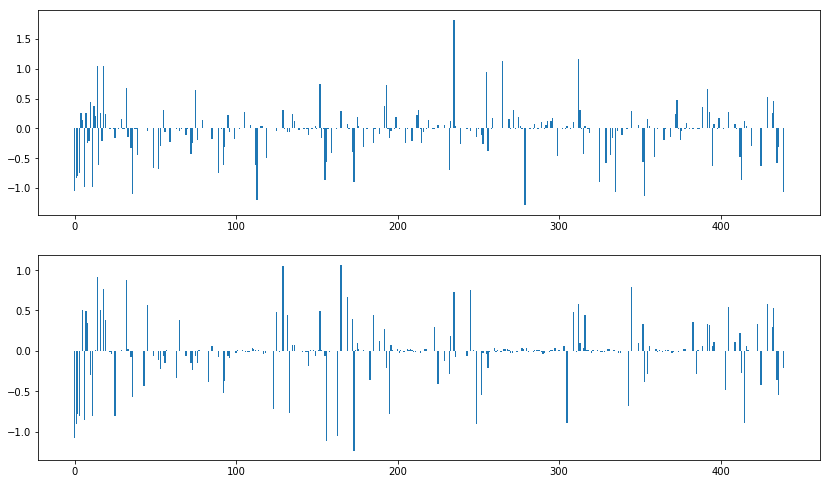

In [90]:
v1 = allW[12,:]
v2 = allW[51,:]
ii = np.arange(allW.shape[1])
fig, ax = plt.subplots(2,1, sharey=False, figsize=(14,8.27))
ax[0].bar(ii, v1)
ax[1].bar(ii, v2)
plt.show()

In [91]:
v1 = param_mat1[62,:]
v2 = param_mat1[63,:]
d = np.linalg.norm(v1-v2)
print(d)

6.644617144325086


In [66]:
ix = 174
dd = Dmat[ix,:]
dd[ix] = 10000
im = np.argmin(dd)
print(im)
print(dd[im])
print(dd[(im-2):(im+3)])

27
29.988771547798535
[42.02255183 43.71202436 29.98877155 45.42838472 37.36539506]


In [94]:
x = [None]*2
x[0] = 'asfds'

x[1] = 'aweffa'
print(x)

['asfds', 'aweffa']


In [103]:
path = '/media/rspace/WanChai/Dropbox/TSOTHOUGHTS/Tensorflow-CODE/maml_ht/FitFunShapes/'
fnm1 = 'HC_k4_Mean_Matrix.pkl'
fnm2 = 'HC_k4_Mean_Matrix1.pkl'

f1 = open(path + fnm1, 'rb')
xx = pickle.load(f1)
w_mean_mat1 = xx['w_mean_mat']
f1.close()

print(w_mean_mat1.shape)

# f2 = open(path + fnm2, 'rb')
# xx = pickle.load(f2)
# w_mean_mat2 = xx['w_mean_mat']
# f2.close()

# np.array_equal(w_mean_mat1, w_mean_mat2)

(4, 481)


In [106]:
ar = np.random.randint(0,9, (3,4))
print(ar)
print(np.argmax(ar, axis=1))

[[0 0 0 2]
 [7 6 8 8]
 [1 4 2 0]]
[3 2 1]


In [108]:
ar1 = np.random.randint(0,9, (3,4))
print(ar1)
print(ar1 == ar)

[[1 3 8 4]
 [7 4 1 2]
 [0 7 6 4]]
[[False False False False]
 [ True False False False]
 [False False False False]]


In [67]:
sigma = 1.0
Hn = [20,20]
initW1 = np.random.normal(0, sigma, [1, Hn[0]])
initW2 = np.random.normal(0, sigma, [Hn[0], Hn[1]])
initW3 = np.random.normal(0, sigma, [Hn[1], 1])
initb1 = np.random.normal(0, sigma, [1, Hn[0]])
initb2 = np.random.normal(0, sigma, [1, Hn[1]])
initb3 = np.random.normal(0, sigma, [1, 1])
v = np.concatenate([initW1.flatten(), initW2.flatten(), initW3.flatten(), \
                           initb1.flatten(), initb2.flatten(),initb3.flatten()])

In [68]:
for i in range(100):
    initW1 = np.random.normal(0, sigma, [1, Hn[0]])
    initW2 = np.random.normal(0, sigma, [Hn[0], Hn[1]])
    initW3 = np.random.normal(0, sigma, [Hn[1], 1])
    initb1 = np.random.normal(0, sigma, [1, Hn[0]])
    initb2 = np.random.normal(0, sigma, [1, Hn[1]])
    initb3 = np.random.normal(0, sigma, [1, 1])
    v1 = np.concatenate([initW1.flatten(), initW2.flatten(), initW3.flatten(), \
                               initb1.flatten(), initb2.flatten(),initb3.flatten()])
    d = np.linalg.norm(v - v1, axis=None)
    print(d)

30.73815220774348
30.14969571614987
30.42398390100349
32.0263794362099
30.717015604312852
31.3630999468253
31.218016334523895
30.104122562772087
29.846878178985822
32.15154942618369
31.65716263127234
28.467607824879444
31.90625376998308
30.723429379704598
30.333829794955857
30.792446074275915
30.909242636332458
31.61493041699983
30.892454494101486
29.776700934562754
30.790453593598578
30.249217493007038
30.72343773872951
30.893695922678386
31.78543864518871
31.690937396835434
30.957927712896737
31.0128761533345
31.46789110434216
30.434508933914245
30.294816794074226
30.04923127836647
30.462412499360276
30.502304671501633
30.18507525610417
31.850506294204326
29.923135699630546
29.566991710905207
31.148978462104196
29.578888456843508
30.99134244502736
30.60212323233729
32.662857811363324
30.911773329644127
30.39128109120864
30.83630965543157
30.882369184457723
29.596939170825067
30.650721923292025
29.007655251713203
30.491830413097883
31.825594472607925
29.54837845806667
32.3982085592946

In [69]:
xx = [(x1-x2)**2 for x1, x2 in zip(v, v1)]
print(xx[:10])
print(np.sqrt(np.sum(xx)))
np.linalg.norm(v - v1, axis=None)

[0.615862102538099, 15.24220107509475, 0.0038831999945641714, 4.399863484378764, 0.06086515153016041, 1.009659878930796, 0.5188365893969593, 0.21875212073386163, 0.20919971477955546, 0.0010564818396367017]
29.85460003683154


29.85460003683154

In [70]:
h0 = Hn[0]
h1 = Hn[0]*Hn[1] + h0
h2 = h1 + Hn[1]
h3 = h2 + Hn[0]
h4 = h3 + Hn[1]
h5 = h4 + 1
print(h5, h4, h3, h2, h1, h0)

481 480 460 440 420 20


In [5]:
from FunGenerator import FunGenerator
FG = FunGenerator(num_pts=0, batch_size=0, randomize=False)

In [9]:
Xtr, Ytr, _, _ = FG.generate(num_pts=5, batch_size=1, x_range=[0,10], randomize=False, train=False, add_noise=False, noise_sd=0.1)
print(Xtr.shape)
#print(Xtr)

(2, 5, 1)


In [16]:
import Fun_utils as fu
N_init = 1
Hn = [3,3]
initW1, initW2, initW3, initb1, initb2, initb3 = fu.GenearteMultipleInitParam(N_init, Hn, sigma=0.05, fnm=None)
print(initW1[0].shape)
print(initW2[0].shape)
print(initW3[0].shape)

(1, 3)
(3, 3)
(3, 1)


In [20]:
Npts = 5
tf.reset_default_graph()
xs = tf.placeholder(tf.float32, [None, 1])
ys = tf.placeholder(tf.float32, [None, 1])
W1 = tf.get_variable('W1', initializer=tf.constant(initW1[0], dtype=tf.float32))
W2 = tf.get_variable('W2', initializer=tf.constant(initW2[0], dtype=tf.float32))
W3 = tf.get_variable('W3', initializer=tf.constant(initW3[0], dtype=tf.float32))
b1 = tf.get_variable('b1', initializer=tf.constant(initb1[0], dtype=tf.float32))
b2 = tf.get_variable('b2', initializer=tf.constant(initb2[0], dtype=tf.float32))
b3 = tf.get_variable('b3', initializer=tf.constant(initb3[0], dtype=tf.float32))
H1 = tf.matmul(xs, W1) + b1
A1 = tf.nn.tanh(H1)
H2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.tanh(H2)
y_hat = tf.matmul(A2, W3) + b3
loss0 = tf.reduce_mean(tf.reduce_sum(tf.square(ys - y_hat), axis=0))
loss = loss0
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [23]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
sess.run(train_step, feed_dict={xs:Xtr[0], ys:Ytr[0]})

None


In [22]:
print(A1.shape)
print(A2.shape)
print(y_hat)

(?, 3)
(?, 3)
Tensor("add_2:0", shape=(?, 1), dtype=float32)


In [6]:
a = np.arange(9) - 4
b = a.reshape((3, 3))
print(type(a))
print(type(b))
b

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([[-4, -3, -2],
       [-1,  0,  1],
       [ 2,  3,  4]])

In [39]:
# distance betwn two vectors
from numpy import linalg as LA
# p-norm : p can be fraction
print(LA.norm(b[0] - b[1], ord=np.Inf))
print(LA.norm(b[0] - b[1], ord=2))
print(LA.norm(b[0] - b[1], ord=1))
print(LA.norm(b[0] - b[1], ord=0.9))
print(LA.norm(b[0] - b[1], ord=0.8))
print(LA.norm(b[0] - b[1], ord=0.5))
print(LA.norm(b[0] - b[1], ord=0.2))
print(LA.norm(b[0] - b[1], ord=0.1))
# NOTE : as p gets smaller, the distance metric increases exponentially

3.0
5.196152422706632
9.0
10.16847867518778
11.844666116572434
27.0
729.0000000000002
177146.9999999998


In [4]:
# pairwise distance matrix for rows of a matrix b
# R's equivalence : dist(X)
from sklearn.metrics.pairwise import euclidean_distances
print(euclidean_distances(b, b))

[[ 0.          5.19615242 10.39230485]
 [ 5.19615242  0.          5.19615242]
 [10.39230485  5.19615242  0.        ]]


In [9]:
from Fun_utils import *
Hn = [20,20]
initW1, initW2, initW3, initb1, initb2, initb3 = GenearteMultipleInitParam(N=1, Hn=Hn, dim_input=1, dim_output=1, sigma=0.1, fnm=None)
iParam = [initW1[0], initW2[0], initW3[0], initb1[0], initb2[0], initb3[0]]

In [23]:
p0_base = np.concatenate((initW1[0].flatten(), initW2[0].flatten(), initW3[0].flatten(), initb1[0].flatten(), initb2[0].flatten(), initb3[0].flatten()), axis=0)
print(type(p0_base))
print(p0_base.shape)

<class 'numpy.ndarray'>
(481,)


In [6]:
# test how np.random.uniform works
xmin = 1.0
xmax = 1.0
x = np.random.uniform(xmin, xmax, [5, 1])
print(x)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [7]:
x = np.linspace(0, 1.0, num=10)
print(x)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [9]:
math.sqrt(25)

5.0

In [15]:
x = np.arange(0, 100, 1)
print(x)
print(x[-200:])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [17]:
x = tf.constant([[[1.,1.,1.],[2.,2.,2.],[3.,3.,3.]],[[4.,4.,4.],[5.,5.,5.],[6.,6.,6.]]])

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print(sess.run(tf.reduce_mean(x, 1)))

[[2. 2. 2.]
 [5. 5. 5.]]


In [6]:
import tensorflow as tf

dim_input = 1
dim_output = 1
dim_hidden = [40,40]
weights = {}
weights['w1'] = tf.Variable(tf.truncated_normal([dim_input, dim_hidden[0]], stddev=0.01))
weights['b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
for i in range(1,len(dim_hidden)):
    weights['w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]], stddev=0.01))
    weights['b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
weights['w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], dim_output], stddev=0.01))
weights['b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([dim_output]))
print(weights.keys())

dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3'])


In [14]:
from scipy.stats import truncnorm
a = -1.5
b = 1.2
r = truncnorm.rvs(a, b, size=[5,10])
print(r.shape)
print(np.max(r))
print(np.min(r))

(5, 10)
0.963464212898782
-1.3620229995312072


In [17]:
x = np.reshape(np.linspace(0, 9, num=10), newshape=(-1, 1))
print(x)

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]


In [25]:
mat = np.random.randint(0,10, size=[10,5])
print(mat)
print(mat[:,2:])

[[2 3 1 7 4]
 [6 6 5 2 5]
 [3 1 6 4 7]
 [7 4 8 3 2]
 [1 1 1 5 4]
 [5 3 1 1 9]
 [0 0 8 4 3]
 [9 2 2 0 1]
 [0 3 6 8 6]
 [7 8 6 1 0]]
[[1 7 4]
 [5 2 5]
 [6 4 7]
 [8 3 2]
 [1 5 4]
 [1 1 9]
 [8 4 3]
 [2 0 1]
 [6 8 6]
 [6 1 0]]


In [28]:
import random
ix = np.arange(mat.shape[0])
print(ix)
random.shuffle(ix)
print(ix)
print(mat[ix,:])

[0 1 2 3 4 5 6 7 8 9]
[5 3 7 8 6 9 1 4 0 2]
[[5 3 1 1 9]
 [7 4 8 3 2]
 [9 2 2 0 1]
 [0 3 6 8 6]
 [0 0 8 4 3]
 [7 8 6 1 0]
 [6 6 5 2 5]
 [1 1 1 5 4]
 [2 3 1 7 4]
 [3 1 6 4 7]]


In [44]:
batch_size = 2
num_pts = 50

mat = np.random.randint(0,10, size=[batch_size,num_pts,1])
print(mat[:,:,0])

[[9 7 3 7 4 3 9 7 6 2 6 6 8 5 8 1 7 8 9 9 1 0 1 0 5 1 3 1 5 5 3 4 3 0 3 3
  0 6 8 7 7 6 9 4 5 1 1 7 3 7]
 [8 5 0 3 4 5 6 2 8 5 2 9 4 2 8 8 4 9 6 0 5 9 4 2 3 8 5 0 8 2 5 7 3 9 8 2
  5 9 6 7 6 4 7 0 1 6 4 4 4 5]]


In [50]:
train_pct = 0.7
val_pct = 0.2
test_pct = 0.1

n_train = int(train_pct * num_pts)
n_val = int(val_pct * num_pts)
n_test = num_pts - n_train - n_val

print('n train', n_train)
print('n val', n_val)
print('n test', n_test)

n train 35
n val 10
n test 5


In [54]:
mat1 = mat[:,:(n_train + n_val),:]

ix = np.arange(n_train + n_val)
#print(ix)
random.shuffle(ix)
#print(ix)
print(len(ix))
ix_train = ix[:n_train]
ix_val = ix[-n_val:]
print(len(ix_val))

x_train = mat1[:,ix_train, :]
x_val = mat1[:,ix_val, :]
x_test = mat[:,-n_test:,:]
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(x_val[:,:,0])
print(x_test[:,:,0])

45
10
(2, 35, 1)
(2, 10, 1)
(2, 5, 1)
[[7 3 9 1 0 0 6 5 3 9]
 [7 8 8 8 9 2 4 8 5 7]]
[[1 1 7 3 7]
 [6 4 4 4 5]]


In [52]:
ix = np.arange(10)
print(ix[:7])
print(ix[-3:])

[0 1 2 3 4 5 6]
[7 8 9]


In [55]:
a = np.random.randint(0,10, size=20)
print(a)
print(np.sort(a))

[0 8 9 4 8 9 7 3 7 4 1 8 4 1 2 0 0 9 9 5]
[0 0 0 1 1 2 3 4 4 4 5 7 7 8 8 8 9 9 9 9]


In [5]:
x1 = max(1, -1, 2, math.inf)
print(x1)

inf
